<a href="https://colab.research.google.com/github/viansebastian/Universiteit/blob/main/Vehicle_Detection_Manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

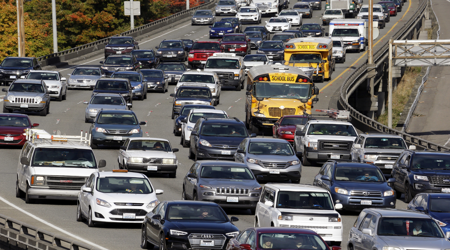

In [179]:
import cv2
import numpy as np
import requests
from PIL import Image
from google.colab.patches import cv2_imshow

image = Image.open(requests.get('https://s.wsj.net/public/resources/images/BN-WB347_3gljM_OR_20171109123717.jpg', stream=True).raw)
image = image.resize((450,250))
image_arr = np.array(image)
image

In [180]:
print(np.array(image))

[[[ 89  61  19]
  [ 85  65  18]
  [ 97  63  22]
  ...
  [174 167 160]
  [183 179 177]
  [154 151 150]]

 [[ 55  41  15]
  [ 64  51  20]
  [101  76  32]
  ...
  [129 119 112]
  [152 143 136]
  [175 170 165]]

 [[106  71  27]
  [ 99  63  23]
  [150  98  45]
  ...
  [126 117 111]
  [124 115 109]
  [129 121 111]]

 ...

 [[ 30  30  30]
  [ 20  20  22]
  [ 17  18  19]
  ...
  [135 140 164]
  [134 140 162]
  [134 140 163]]

 [[ 69  67  62]
  [ 38  36  36]
  [ 33  32  33]
  ...
  [133 135 151]
  [131 132 148]
  [130 131 147]]

 [[ 84  79  75]
  [ 72  69  64]
  [ 69  65  61]
  ...
  [168 165 162]
  [166 163 156]
  [169 165 159]]]


In [181]:
def dilation(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    result = np.zeros((image_height, image_width), dtype=np.uint8)

    # Define the center of the kernel
    anchor_x, anchor_y = kernel_height // 2, kernel_width // 2

    for i in range(image_height):
        for j in range(image_width):
            if image[i, j] > 0:  # Check for thresholded value
                # Iterate over the kernel and check for overlap with the image
                for k in range(kernel_height):
                    for l in range(kernel_width):
                        # Calculate coordinates in the image for the current kernel element
                        x = i + k - anchor_x
                        y = j + l - anchor_y
                        if 0 <= x < image_height and 0 <= y < image_width and kernel[k, l] > 0:
                            result[x, y] = 255  # Set to 255 for white in binary image

    return result

In [182]:
def erosion(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    result = np.zeros((image_height, image_width), dtype=np.uint8)

    # Define the center of the kernel
    anchor_x, anchor_y = kernel_height // 2, kernel_width // 2

    for i in range(image_height):
        for j in range(image_width):
            # Assume all pixels in the neighborhood match the kernel value (255)
            all_match = True

            # Iterate over the kernel and check for overlap with the image
            for k in range(kernel_height):
                for l in range(kernel_width):
                    # Calculate coordinates in the image for the current kernel element
                    x = i + k - anchor_x
                    y = j + l - anchor_y

                    # Check if the pixel in the image is outside the image bounds
                    # or if it doesn't match the kernel value
                    if (
                        x < 0
                        or x >= image_height
                        or y < 0
                        or y >= image_width
                        or image[x, y] == 0
                    ):
                        all_match = False
                        break  # Exit the inner loop

                if not all_match:
                    break  # Exit the outer loop

            if all_match:
                result[i, j] = 255

    return result



In [183]:
def close(image, kernel):
  dilated = dilation(image, kernel)
  result = erosion(dilated, kernel)
  return result

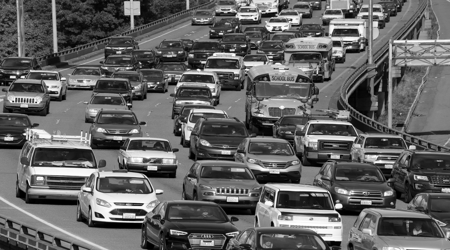

In [184]:
image_gray = cv2.cvtColor(image_arr, cv2.COLOR_BGR2GRAY)
Image.fromarray(image_gray)

In [185]:
# threshold_value, thresholded = cv2.threshold(image_gray, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Image.fromarray(thresholded)
# # print(threshold_value)

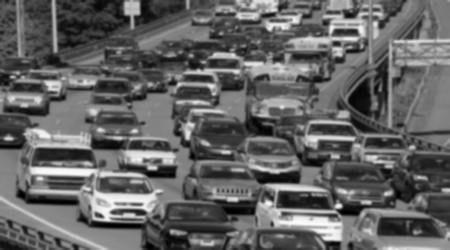

In [186]:
blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)
Image.fromarray(blurred)

# blurred = cv2.GaussianBlur(thresholded, (5, 5), 0)
# Image.fromarray(blurred)

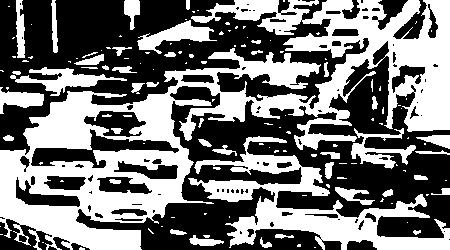

In [187]:
threshold_value, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
Image.fromarray(thresholded)

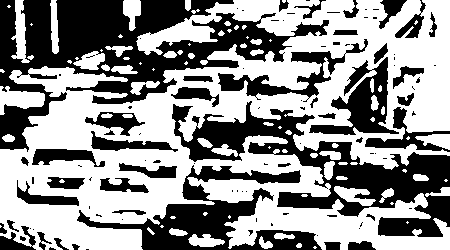

In [188]:
kernel_custom = np.array([[0, 1, 0],
                          [1, 1, 1],
                          [0, 1, 0]], np.uint8)

# Perform dilation
dilated = dilation(thresholded, kernel_custom)
# dilated = dilation(blurred, np.ones((3,3)))

# Display the dilated image
Image.fromarray(dilated)

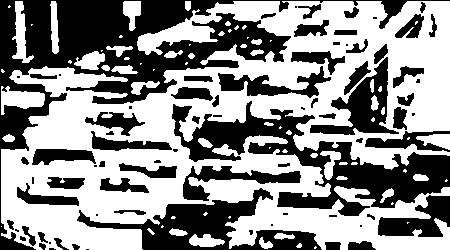

In [189]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
closed_result = close(dilated, kernel)
Image.fromarray(closed_result)

In [190]:
import requests
from io import BytesIO
import os

url = "https://raw.githubusercontent.com/andrewssobral/vehicle_detection_haarcascades/master/cars.xml"
response = requests.get(url)

if response.status_code == 200:

    content = response.content

    with open('cars.xml', 'wb') as file:
        file.write(content)

    if os.path.exists('cars.xml'):
        print("Haar Cascade file downloaded successfully.")
        car_cascade_src = 'cars.xml'
    else:
        print("Error: 'cars.xml' not found.")
else:
    print(f"Error downloading Haar Cascade file. Status code: {response.status_code}")


Haar Cascade file downloaded successfully.


In [191]:
car_cascade_src = 'cars.xml'
car_cascade = cv2.CascadeClassifier(car_cascade_src)
cars = car_cascade.detectMultiScale(closed_result, 1.1, 1)
cars

array([[385,   6,  45,  45],
       [198,  33,  80,  80],
       [230,  48,  68,  68],
       [  3,  51,  57,  57],
       [162,  57,  57,  57],
       [294,  86,  70,  70],
       [  5,  91, 101, 101],
       [356, 118,  43,  43],
       [234, 120,  48,  48],
       [138, 142,  50,  50],
       [ 32, 142,  63,  63],
       [244, 138,  66,  66],
       [ 83, 139,  76,  76],
       [326, 178,  50,  50],
       [264, 153,  80,  80]], dtype=int32)

15  cars found


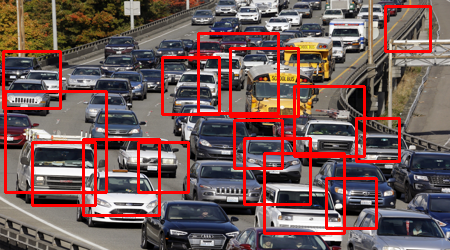

In [192]:
cnt = 0
for (x,y,w,h) in cars:
    cv2.rectangle(image_arr,(x,y),(x+w,y+h),(255,0,0),2)
    cnt += 1
print(cnt, " cars found")
Image.fromarray(image_arr)